<a href="https://colab.research.google.com/github/abhijeetk597/NLP-Projects/blob/master/tweets_clf_disaster_or_not_%26_nlp_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweets Classification (Disaster or Non-Disaster) and NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech). Another common term for NLP problem is sequence to sequence problems (seq2seq).

In [ ]:
## Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9b152e3f-d78d-29ac-3ccc-0a3aa18b2af0)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-12-24 10:06:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-24 10:06:25 (89.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's intro to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data('nlp_getting_started.zip')

--2023-12-24 10:06:35--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 142.251.172.207, 108.177.112.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.02s   

2023-12-24 10:06:35 (30.7 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n{text}\n')
  print('---\n')


Target: 1 (real disaster)
Text:
.@APHL responds: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/cGdj3dRso9

---

Target: 0 (not real disaster)
Text:
Take this China get demolished and sent back to the fucking stone age

---

Target: 0 (not real disaster)
Text:
#ArrestpastorNganga it so worrying 2 see how some police officers in Kenya have sunk to low to the point of collaborating with pick pockets

---

Target: 0 (not real disaster)
Text:
I didn`t want to hurt you but the fear drove me to do it ............... Midnight

---

Target: 1 (real disaster)
Text:
When Houston and NYC collide. ?? @pageparkescorp @chloeunguyen @laurensicle @charstevens97 @tiara_marei #gemma #boweÛ_ http://t.co/9wowPs78VD

---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use tts to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).



### Text Vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default textvectorization parameters
max_vocab_length = 10000
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence} \n')
text_vectorizer([random_sentence])

Original text:
 South Sac I5 S / I5 S 43rd Ave Ofr **Trfc Collision-No Inj** http://t.co/GpxQBYzYu4 



<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 593, 2307, 1837,  236, 1837,  236, 4176, 1094,    1, 1456, 2516,
        1834,    1,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we are going to use TensorFlow embedding layer.

The parameters we care most about for our embedding layer:
* input_dim = the size of our vocabulary
* output_dim = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the sequences being passed to the embedding layer


In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length)
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
        \n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Drunk Meals 101: What To Cook When You're Totally Obliterated http://t.co/Wj0U59mPpB        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02453152,  0.00558218, -0.01980569, ..., -0.04717863,
         -0.03033671, -0.04677761],
        [-0.04243243, -0.04207904,  0.02076883, ..., -0.03953175,
         -0.00716195,  0.03213445],
        [-0.03368683,  0.0115291 ,  0.01945882, ..., -0.02737302,
          0.02468951,  0.00520603],
        ...,
        [ 0.00199439, -0.03669796,  0.01128113, ...,  0.03400563,
          0.04478944, -0.01412916],
        [ 0.00199439, -0.03669796,  0.01128113, ...,  0.03400563,
          0.04478944, -0.01412916],
        [ 0.00199439, -0.03669796,  0.01128113, ...,  0.03400563,
          0.04478944, -0.01412916]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02453152,  0.00558218, -0.01980569, -0.04823561, -0.03809633,
         0.0169319 , -0.01417645,  0.04828495, -0.00669227, -0.00234965,
        -0.02137402,  0.0187856 , -0.00380026, -0.01170347,  0.0481001 ,
        -0.04646368,  0.04753435, -0.00381316,  0.01878444,  0.04651735,
        -0.03005155, -0.03340252, -0.02941768,  0.04598605,  0.04846123,
        -0.00095411,  0.01395986, -0.0472925 , -0.04258752,  0.0481878 ,
         0.02480692, -0.03683906,  0.00851689,  0.01910886,  0.03608185,
        -0.04762569,  0.04613547, -0.02674389, -0.00406947, -0.03725236,
         0.04560151, -0.01990544, -0.03482456,  0.03743652,  0.00549005,
         0.03442707, -0.00837545, -0.04276215, -0.04728603,  0.0048087 ,
        -0.01114846,  0.02210034,  0.02059877,  0.00252954, -0.04759971,
        -0.04380804,  0.01891389,  0.00060136, -0.01159351,  0.0336143 ,
        -0.01346208, -0.00354887,  0.04654844, -0.03915798, -0.04754441,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* model 0: Naive Bayes (baseline) - Scikit-Learn
* model 1: Feed-forward Neural network (dense model)
* model 2: LSTM model RNN
* model 3: GRU model RNN
* model 4: Bidirectional-LSTM model RNN
* model 5: 1D Convolutional Neural Network CNN
* model 6: TFHub Pretrained Feature Extractor - transfer learning
* model 7: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

🔑**Note:** It's a common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()), # convert words to numbers using tfidf
                    ('clf', MultinomialNB()) # model the text
                  ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100}%')

Our baseline model achieves an accuracy of: 79.26509186351706%


In [ ]:
# Make prediction
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  '''
  # Calulate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision_recall_fscore_support
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### model 1: simple dense model feed forward nn

In [ ]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboard logs
SAVE_DIR = 'model_logs'

In [ ]:
# Build model with the functional API

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1d strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid activation else softmax for multiclass classification
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20231224-100643
Epoch 1/5
215/215 [==============================] - 11s 33ms/step - loss: 0.6107 - accuracy: 0.6907 - val_loss: 0.5343 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4401 - accuracy: 0.8174 - val_loss: 0.4696 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3459 - accuracy: 0.8624 - val_loss: 0.4579 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2832 - accuracy: 0.8913 - val_loss: 0.4645 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2362 - accuracy: 0.9129 - val_loss: 0.4898 - val_accuracy: 0.7848


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4898 - accuracy: 0.7848


[0.48979079723358154, 0.7847769260406494]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
# Create model with maxpool layer
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1d strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid activation else softmax for multiclass classification
model_1_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

# Compile model
model_1_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_1_1_history = model_1_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20231224-100709
Epoch 1/5
215/215 [==============================] - 9s 37ms/step - loss: 0.4927 - accuracy: 0.8524 - val_loss: 0.4883 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3128 - accuracy: 0.8930 - val_loss: 0.4779 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2426 - accuracy: 0.9129 - val_loss: 0.4898 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1980 - accuracy: 0.9279 - val_loss: 0.5106 - val_accuracy: 0.7966
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1642 - accuracy: 0.9431 - val_loss: 0.5276 - val_accuracy: 0.8071


In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape, model_1_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.37040877],
        [0.7263209 ],
        [0.995606  ],
        [0.59371823],
        [0.1456312 ],
        [0.9643846 ],
        [0.8580748 ],
        [0.99473614],
        [0.96699464],
        [0.7534047 ]], dtype=float32))

In [ ]:
# Convert model pred probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 74.1469816272966,
 'precision': 0.7437030970462766,
 'recall': 0.7414698162729659,
 'f1': 0.7419115725972362}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

model 1 results are almost equal to baseline results

### Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights.shape, embed_weights

((10000, 128),
 array([[-0.05815087, -0.07379922,  0.10956339, ...,  0.1747533 ,
         -0.07806609, -0.06247938],
        [-0.0705381 , -0.07331281,  0.02568771, ..., -0.05816095,
         -0.0789742 , -0.0674535 ],
        [-0.03628827, -0.04755588,  0.13301533, ...,  0.06315365,
         -0.03989548, -0.05525791],
        ...,
        [-0.03034399, -0.03217765,  0.00792981, ...,  0.02223711,
          0.03854376,  0.01592634],
        [ 0.03969097,  0.08986592,  0.08607323, ..., -0.0812843 ,
          0.06572248,  0.00208289],
        [ 0.10820298,  0.10517111,  0.05704312, ..., -0.03993412,
          0.0883773 ,  0.13439375]], dtype=float32))

Now we've got the encoding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector.https://projector.tensorflow.org/

And tensorFlow also has an incredible guide on word embeddings themselves.https://www.tensorflow.org/text/guide/word_embeddings


In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNNs)

RNNs are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.



### Model 2: LSTM

LSTM = long short term memory

our structure of an RNN typically looks like this:

```
Input (txt) -> Tokenize -> Embedding -> Layers (RNN/dense) -> output (label probability)
```

In [ ]:
# Create an LSTM model

from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')


(None, 15, 128)
(None, 15, 64)
(None, 64)


In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231224-100727
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.2143 - accuracy: 0.9242 - val_loss: 0.6116 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1500 - accuracy: 0.9439 - val_loss: 0.7215 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1210 - accuracy: 0.9543 - val_loss: 0.6790 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0975 - accuracy: 0.9629 - val_loss: 0.8747 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0794 - accuracy: 0.9695 - val_loss: 1.1164 - val_accuracy: 0.7769


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.7521415e-03],
       [9.0895504e-01],
       [9.9999142e-01],
       [2.3552826e-02],
       [4.3062339e-04],
       [9.9995720e-01],
       [9.9129581e-01],
       [9.9999511e-01],
       [9.9999249e-01],
       [5.9091216e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results


{'accuracy': 77.69028871391076,
 'precision': 0.7767817074616054,
 'recall': 0.7769028871391076,
 'f1': 0.7760612229809302}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Create an LSTM model

from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2_2 = tf.keras.Model(inputs, outputs, name='model_2_2_LSTM')

# Compile the model
model_2_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

# Fit the model
model_2_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_2_LSTM')])
# Make predictions with LSTM model
model_2_2_pred_probs = model_2_2.predict(val_sentences)

# Convert model 2 pred probs to labels
model_2_2_preds = tf.squeeze(tf.round(model_2_2_pred_probs))

# Calculate model 2 results
model_2_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_2_preds)
model_2_2_results

(None, 15, 128)
(None, 15, 64)
(None, 64)
Saving TensorBoard log files to: model_logs/model_2_2_LSTM/20231224-100752
Epoch 1/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0610 - accuracy: 0.9737 - val_loss: 1.5389 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0575 - accuracy: 0.9747 - val_loss: 1.1269 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0484 - accuracy: 0.9775 - val_loss: 1.4678 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0434 - accuracy: 0.9797 - val_loss: 1.6050 - val_accuracy: 0.7808
Epoch 5/5
24/24 [==============================] - 1s 4ms/step


{'accuracy': 58.3989501312336,
 'precision': 0.6406140931988245,
 'recall': 0.583989501312336,
 'f1': 0.4972446087685258}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build an RNN using GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# FIt the model
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231224-100814
Epoch 1/5
215/215 [==============================] - 10s 32ms/step - loss: 0.1435 - accuracy: 0.9428 - val_loss: 0.7756 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0694 - accuracy: 0.9746 - val_loss: 0.8160 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0588 - accuracy: 0.9761 - val_loss: 1.0021 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0517 - accuracy: 0.9785 - val_loss: 1.0909 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0405 - accuracy: 0.9788 - val_loss: 1.2436 - val_accuracy: 0.7717


In [ ]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.5753186e-03],
       [8.0401695e-01],
       [9.9984324e-01],
       [1.3896292e-01],
       [1.3575787e-04],
       [9.9973315e-01],
       [9.1716605e-01],
       [9.9992847e-01],
       [9.9992204e-01],
       [9.8858625e-01]], dtype=float32)

In [ ]:
# Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.7724094757924029,
 'recall': 0.7716535433070866,
 'f1': 0.7700698633249685}

### Model 4: Bidirectional LSTM RNN

In [ ]:
# Build a bidiectional RNN
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_Bidirectional')

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231224-100838
Epoch 1/5
215/215 [==============================] - 16s 51ms/step - loss: 0.1119 - accuracy: 0.9623 - val_loss: 0.9119 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0487 - accuracy: 0.9785 - val_loss: 1.0711 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0408 - accuracy: 0.9813 - val_loss: 1.2950 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0387 - accuracy: 0.9822 - val_loss: 1.4299 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0338 - accuracy: 0.9837 - val_loss: 1.6192 - val_accuracy: 0.7677


In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[1.8339570e-03],
       [9.0036905e-01],
       [9.9999046e-01],
       [8.2075350e-02],
       [2.9524470e-05],
       [9.9984717e-01],
       [9.8787153e-01],
       [9.9999392e-01],
       [9.9999404e-01],
       [9.9953341e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results


{'accuracy': 76.77165354330708,
 'precision': 0.7683074753719822,
 'recall': 0.7677165354330708,
 'f1': 0.7661635916954678}

In [ ]:
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.7724094757924029,
 'recall': 0.7716535433070866,
 'f1': 0.7700698633249685}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width).. however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

## Model 5: Conv1D

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# Create 1-d conv layer to model sequence

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

# Compile conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20231224-104011
Epoch 1/5
215/215 [==============================] - 10s 39ms/step - loss: 0.1209 - accuracy: 0.9616 - val_loss: 0.8767 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0659 - accuracy: 0.9761 - val_loss: 1.0914 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0563 - accuracy: 0.9790 - val_loss: 1.1427 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0490 - accuracy: 0.9796 - val_loss: 1.2136 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0479 - accuracy: 0.9794 - val_loss: 1.2526 - val_accuracy: 0.7533


In [ ]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[1.8587632e-01],
       [1.3816643e-01],
       [9.9991465e-01],
       [4.2024206e-02],
       [3.4635536e-07],
       [9.9129158e-01],
       [9.3879867e-01],
       [9.9998820e-01],
       [9.9999976e-01],
       [8.2633716e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.32808398950131,
 'precision': 0.755746241425447,
 'recall': 0.7532808398950132,
 'f1': 0.7503015106708947}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([sample_sentence,
    "I am a sentence for which I would like to get its embedding"])
print(embeddings[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [ ]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231224-115236
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.4834 - accuracy: 0.7930 - val_loss: 0.4438 - val_accuracy: 0.8097
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4084 - accuracy: 0.8170 - val_loss: 0.4370 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3956 - accuracy: 0.8263 - val_loss: 0.4276 - val_accuracy: 0.8215
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3848 - accuracy: 0.8297 - val_loss: 0.4261 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3757 - accuracy: 0.8365 - val_loss: 0.4246 - val_accuracy: 0.8176


In [ ]:
# Make predictions with USE TF hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.2066071 ],
       [0.78074867],
       [0.99344504],
       [0.23824012],
       [0.73620266],
       [0.800758  ],
       [0.9871514 ],
       [0.99111825],
       [0.96474975],
       [0.11059092]], dtype=float32)

In [ ]:
# convert predictions probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8180726407863905,
 'recall': 0.8175853018372703,
 'f1': 0.8167845198250385}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_10_percent.head(), len(train_10_percent)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Check the number of targets in our subset of data
train_10_percent['target'].value_counts('')

0    413
1    348
Name: target, dtype: int64

To create a model the same as a previous model you can use the `tf.keras.models.clone_model()` method

In [ ]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Let's build a model the same as model_7
model_7 = tf.keras.Sequential([
          sentence_encoder_layer,
          layers.Dense(64, activation='relu'),
          layers.Dense(1, activation='sigmoid', name='output_layer')
          ], name='model_7_USE')

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will be same as model_6)
model_7.summary()


Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20231224-122036
Epoch 1/5
24/24 [==============================] - 2s 44ms/step - loss: 0.6742 - accuracy: 0.6662 - val_loss: 0.6362 - val_accuracy: 0.8018
Epoch 2/5
24/24 [==============================] - 1s 46ms/step - loss: 0.6020 - accuracy: 0.7963 - val_loss: 0.5558 - val_accuracy: 0.8058
Epoch 3/5
24/24 [==============================] - 0s 21ms/step - loss: 0.5231 - accuracy: 0.7989 - val_loss: 0.4842 - val_accuracy: 0.8071
Epoch 4/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4664 - accuracy: 0.8068 - val_loss: 0.4378 - val_accuracy: 0.8123
Epoch 5/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4298 - accuracy: 0.8147 - val_loss: 0.4086 - val_accuracy: 0.8281


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.21065442],
       [0.82869256],
       [0.90952003],
       [0.30561757],
       [0.80053425],
       [0.83715284],
       [0.8901312 ],
       [0.9390112 ],
       [0.80525357],
       [0.06634632]], dtype=float32)

In [ ]:
# turn probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model 7 prediction
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

model_7_results

{'accuracy': 82.80839895013123,
 'precision': 0.8280050327294423,
 'recall': 0.8280839895013123,
 'f1': 0.827720143240831}

In [ ]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8180726407863905,
 'recall': 0.8175853018372703,
 'f1': 0.8167845198250385}

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [ ]:
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Let's build a model the same as model_7 again
model_7 = tf.keras.Sequential([
          sentence_encoder_layer,
          layers.Dense(64, activation='relu'),
          layers.Dense(1, activation='sigmoid', name='output_layer')
          ], name='model_7_USE')

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model to the 10% training data subset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent_correct_split')])
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)

# turn probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

# Evaluate model 7 prediction
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

model_7_results

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20231224-124830
Epoch 1/5
22/22 [==============================] - 3s 48ms/step - loss: 0.6642 - accuracy: 0.7095 - val_loss: 0.6428 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5917 - accuracy: 0.8088 - val_loss: 0.5833 - val_accuracy: 0.7769
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5162 - accuracy: 0.8161 - val_loss: 0.5357 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4592 - accuracy: 0.8234 - val_loss: 0.5041 - val_accuracy: 0.7782
Epoch 5/5
24/24 [==============================] - 1s 9ms/step


{'accuracy': 78.21522309711287,
 'precision': 0.7831103148931962,
 'recall': 0.7821522309711286,
 'f1': 0.7806413638617515}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1D': model_5_results,
                                  '6_use_encoder': model_6_results,
                                  '7_use_encoder_10_percent': model_7_results})

In [ ]:
all_model_results  = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,74.146982,0.743703,0.741470,0.741912
2_lstm,77.690289,0.776782,0.776903,0.776061
3_gru,77.165354,0.772409,0.771654,0.770070
4_bidirectional,76.771654,0.768307,0.767717,0.766164
5_conv1D,75.328084,0.755746,0.753281,0.750302
6_use_encoder,81.758530,0.818073,0.817585,0.816785
7_use_encoder_10_percent,78.215223,0.783110,0.782152,0.780641


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.741470,0.743703,0.741470,0.741912
2_lstm,0.776903,0.776782,0.776903,0.776061
3_gru,0.771654,0.772409,0.771654,0.770070
4_bidirectional,0.767717,0.768307,0.767717,0.766164
5_conv1D,0.753281,0.755746,0.753281,0.750302
6_use_encoder,0.817585,0.818073,0.817585,0.816785
7_use_encoder_10_percent,0.782152,0.783110,0.782152,0.780641


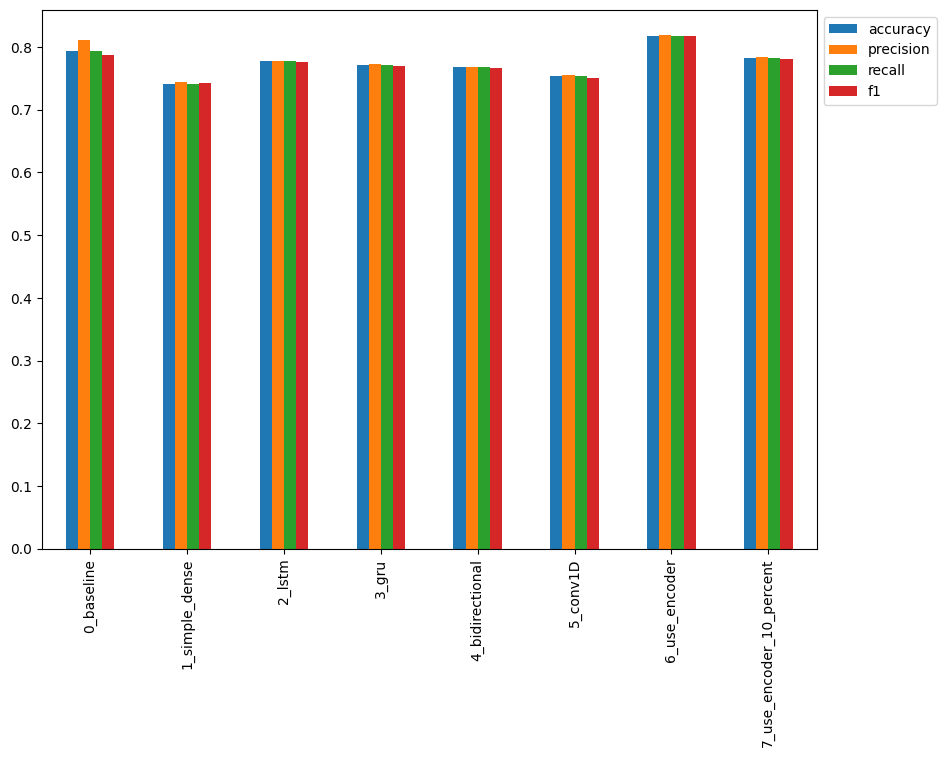

In [ ]:
# Plot and compare all of the model resutls
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

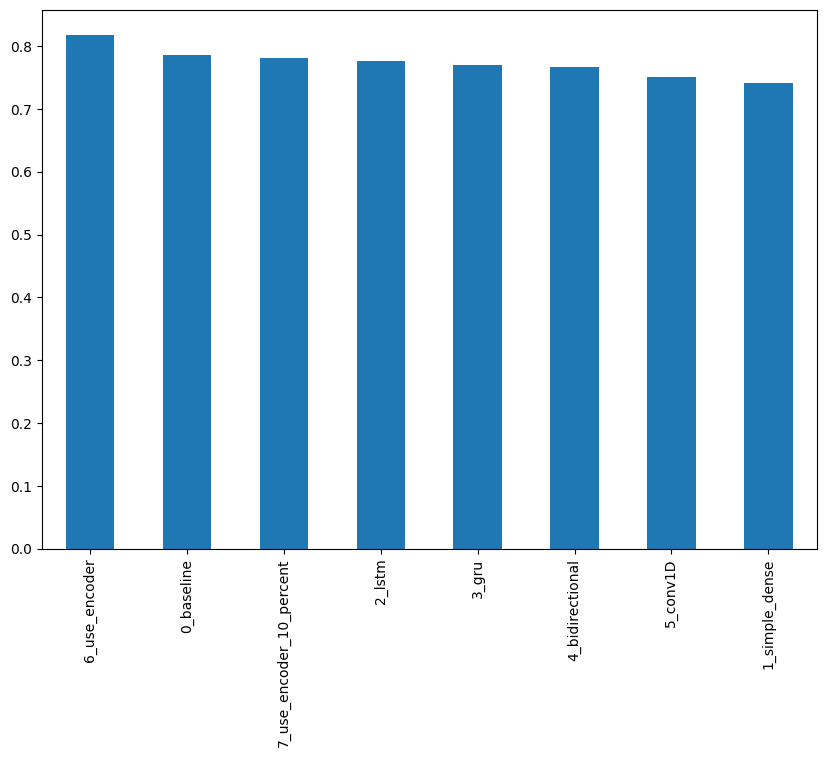

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7));